In [169]:
using Graphs
using Plots
using LinearAlgebra
include("../inference/zero_patient.jl")
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear);

In [170]:
function zp_bp_bondsize(T::Integer, N::Integer, λ::Real, κ::Real, γ::Real, nobs::Integer,
        bonddims::AbstractVector{Int})
    
    auc_bp = zeros(length(bonddims))
    
    gg = random_regular_graph(N, 3)
    g = IndexedGraph(gg)
    p⁰ = fill([1-γ, γ], N)
    sis = SIS(g, λ, κ, T; p⁰) 
    bp = mpdbp(sis)
    # sample one trajectory: the truth. Add observations on final time
    x = draw_node_observations!(bp, nobs, last_time=true)
    # see who are the zero patients
    true_zp = findall(isequal(I), x[:,1])  
    
    for j in eachindex(bonddims)
        svd_trunc = TruncBond(bonddims[j])
        guess_bp, _ = find_zero_patients_bp(bp; svd_trunc, require_convergence=false)
        auc_bp[j] = auc(guess_bp, true_zp)
    end
    auc_bp
end

zp_bp_bondsize (generic function with 2 methods)

In [186]:
T = 10
N = 20
k = 3
λ = 0.2
κ = 0.1
γ = 3/N
nobs = N
bonddims = 2:2:10;

In [188]:
aucs_bp = Vector{Float64}[];

In [ ]:
ninstances = 100
for n in 1:ninstances
    println("### instance $n of $ninstances")
    auc_bp = zp_bp_bondsize(T, N, λ, κ, γ, nobs, bonddims)
    push!(aucs_bp, auc_bp)
    flush(stdout)
end

SIS with: P(S→I)=λ=0.2, P(I→S)=κ=0.1. P(zero patient)=γ=0.15
Random regular N=20, k=3. T=10, 20 random observations from the prior at final time


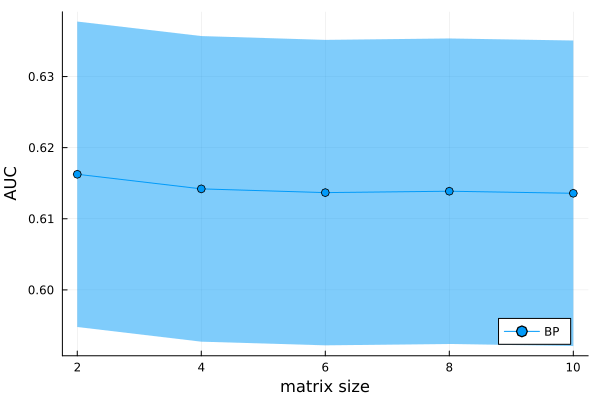

In [192]:
aucs_bp_avg = mean(aucs_bp)
aucs_bp_std = std(aucs_bp) ./ sqrt(length(aucs_bp))

println("SIS with: P(S→I)=λ=$λ, P(I→S)=κ=$κ. P(zero patient)=γ=$γ")
println("Random regular N=$N, k=3. T=$T, $N random observations from the prior at final time")

pl = plot(xlabel="matrix size", ylabel="AUC", xticks=bonddims, legend=:bottomright)
plot!(pl, bonddims, aucs_bp_avg, ribbon=aucs_bp_std, label="BP", m=:o)

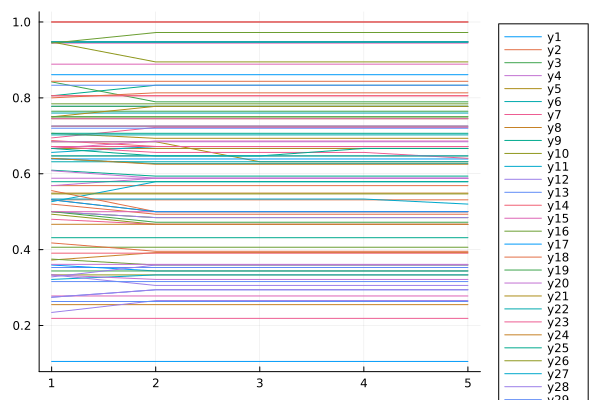

In [196]:
plot(reduce(hcat, aucs_bp), legend=:outertopright)